In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
DATASET_PATH = '/content/drive/MyDrive/weather_dataset/dataset'
OUTPUT_PATH = '/content/drive/MyDrive/processed_data'

In [ ]:
# Image parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.1

In [ ]:
# Class information
CLASS_NAMES = ['cloudy', 'foggy', 'rainy', 'shine', 'sunrise']
NUM_CLASSES = len(CLASS_NAMES)

print(f"Image Size: {IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Number of Classes: {NUM_CLASSES}")
print(f"Classes: {CLASS_NAMES}")

Image Size: (224, 224)
Batch Size: 32
Number of Classes: 5
Classes: ['cloudy', 'foggy', 'rainy', 'shine', 'sunrise']


In [ ]:
def load_dataset_info():
    """Load all image paths and labels"""
    image_paths = []
    labels = []

    for idx, class_name in enumerate(CLASS_NAMES):
        class_path = os.path.join(DATASET_PATH, class_name)
        if os.path.exists(class_path):
            for img_file in os.listdir(class_path):
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(class_path, img_file))
                    labels.append(idx)

    return np.array(image_paths), np.array(labels)

all_image_paths, all_labels = load_dataset_info()
print(f"Total images loaded: {len(all_image_paths)}")

Total images loaded: 1500


In [ ]:
# Class distribution
unique, counts = np.unique(all_labels, return_counts=True)
print("\nClass Distribution:")
for cls_idx, count in zip(unique, counts):
    print(f"  {CLASS_NAMES[cls_idx]}: {count} images ({count/len(all_labels)*100:.1f}%)")


Class Distribution:
  cloudy: 300 images (20.0%)
  foggy: 300 images (20.0%)
  rainy: 300 images (20.0%)
  shine: 250 images (16.7%)
  sunrise: 350 images (23.3%)


ANALYZE IMAGE QUALITY

In [ ]:
def analyze_image_quality(sample_size=100):
    """Analyze image quality and dimensions"""
    sample_indices = np.random.choice(len(all_image_paths), min(sample_size, len(all_image_paths)), replace=False)

    dimensions = []
    corrupted_images = []

    for idx in sample_indices:
        try:
            img = Image.open(all_image_paths[idx])
            dimensions.append(img.size)
            img.verify()
        except:
            corrupted_images.append(all_image_paths[idx])

    dimensions = np.array(dimensions)
    print("\nImage Quality Analysis:")
    print(f"  Sample size: {len(sample_indices)}")
    print(f"  Average dimensions: {dimensions.mean(axis=0).astype(int)}")
    print(f"  Min dimensions: {dimensions.min(axis=0)}")
    print(f"  Max dimensions: {dimensions.max(axis=0)}")
    print(f"  Corrupted images: {len(corrupted_images)}")

    return corrupted_images

corrupted = analyze_image_quality()


Image Quality Analysis:
  Sample size: 100
  Average dimensions: [627 451]
  Min dimensions: [211 121]
  Max dimensions: [2560 1600]
  Corrupted images: 0


SPLIT DATASET

In [ ]:
# First split: separate test set
X_temp, X_test, y_temp, y_test = train_test_split(
    all_image_paths, all_labels,
    test_size=TEST_SPLIT,
    stratify=all_labels,
    random_state=42
)

# Second split: separate train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=VALIDATION_SPLIT/(1-TEST_SPLIT),
    stratify=y_temp,
    random_state=42
)

print(f"\nDataset Split:")
print(f"  Training samples: {len(X_train)} ({len(X_train)/len(all_image_paths)*100:.1f}%)")
print(f"  Validation samples: {len(X_val)} ({len(X_val)/len(all_image_paths)*100:.1f}%)")
print(f"  Test samples: {len(X_test)} ({len(X_test)/len(all_image_paths)*100:.1f}%)")


Dataset Split:
  Training samples: 1050 (70.0%)
  Validation samples: 300 (20.0%)
  Test samples: 150 (10.0%)


COMPUTE CLASS WEIGHTS (for imbalanced data)

In [ ]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

print("\nClass Weights (for handling imbalance):")
for idx, weight in class_weight_dict.items():
    print(f"  {CLASS_NAMES[idx]}: {weight:.3f}")


Class Weights (for handling imbalance):
  cloudy: 1.000
  foggy: 1.000
  rainy: 1.000
  shine: 1.200
  sunrise: 0.857


DATA AUGMENTATION

In [ ]:
# Training data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0,1]
    rotation_range=20,  # Random rotation
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    horizontal_flip=True,  # Random horizontal flip
    zoom_range=0.2,  # Random zoom
    shear_range=0.15,  # Shear transformation
    brightness_range=[0.8, 1.2],  # Random brightness
    fill_mode='nearest'  # Fill strategy for new pixels
)

# Validation data (only normalization, no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

# Test data (only normalization, no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

CREATE DATA GENERATORS

In [ ]:
def create_generator_from_arrays(datagen, X, y, batch_size, shuffle=True):
    """Create data generator from arrays"""
    df = pd.DataFrame({
        'filename': X,
        'class': y.astype(str)
    })

    generator = datagen.flow_from_dataframe(
        dataframe=df,
        x_col='filename',
        y_col='class',
        target_size=IMG_SIZE,
        batch_size=batch_size,
        class_mode='sparse',
        shuffle=shuffle,
        seed=42
    )

    return generator

print("\n" + "="*60)
print("CREATING DATA GENERATORS")
print("="*60)

train_generator = create_generator_from_arrays(
    train_datagen, X_train, y_train, BATCH_SIZE, shuffle=True
)

val_generator = create_generator_from_arrays(
    val_datagen, X_val, y_val, BATCH_SIZE, shuffle=False
)

test_generator = create_generator_from_arrays(
    test_datagen, X_test, y_test, BATCH_SIZE, shuffle=False
)

print(f"Training generator: {len(train_generator)} batches")
print(f"Validation generator: {len(val_generator)} batches")
print(f"Test generator: {len(test_generator)} batches")


CREATING DATA GENERATORS
Found 1050 validated image filenames belonging to 5 classes.
Found 300 validated image filenames belonging to 5 classes.
Found 150 validated image filenames belonging to 5 classes.
Training generator: 33 batches
Validation generator: 10 batches
Test generator: 5 batches


VISUALIZE AUGMENTED SAMPLES


Visualizing augmented training samples...


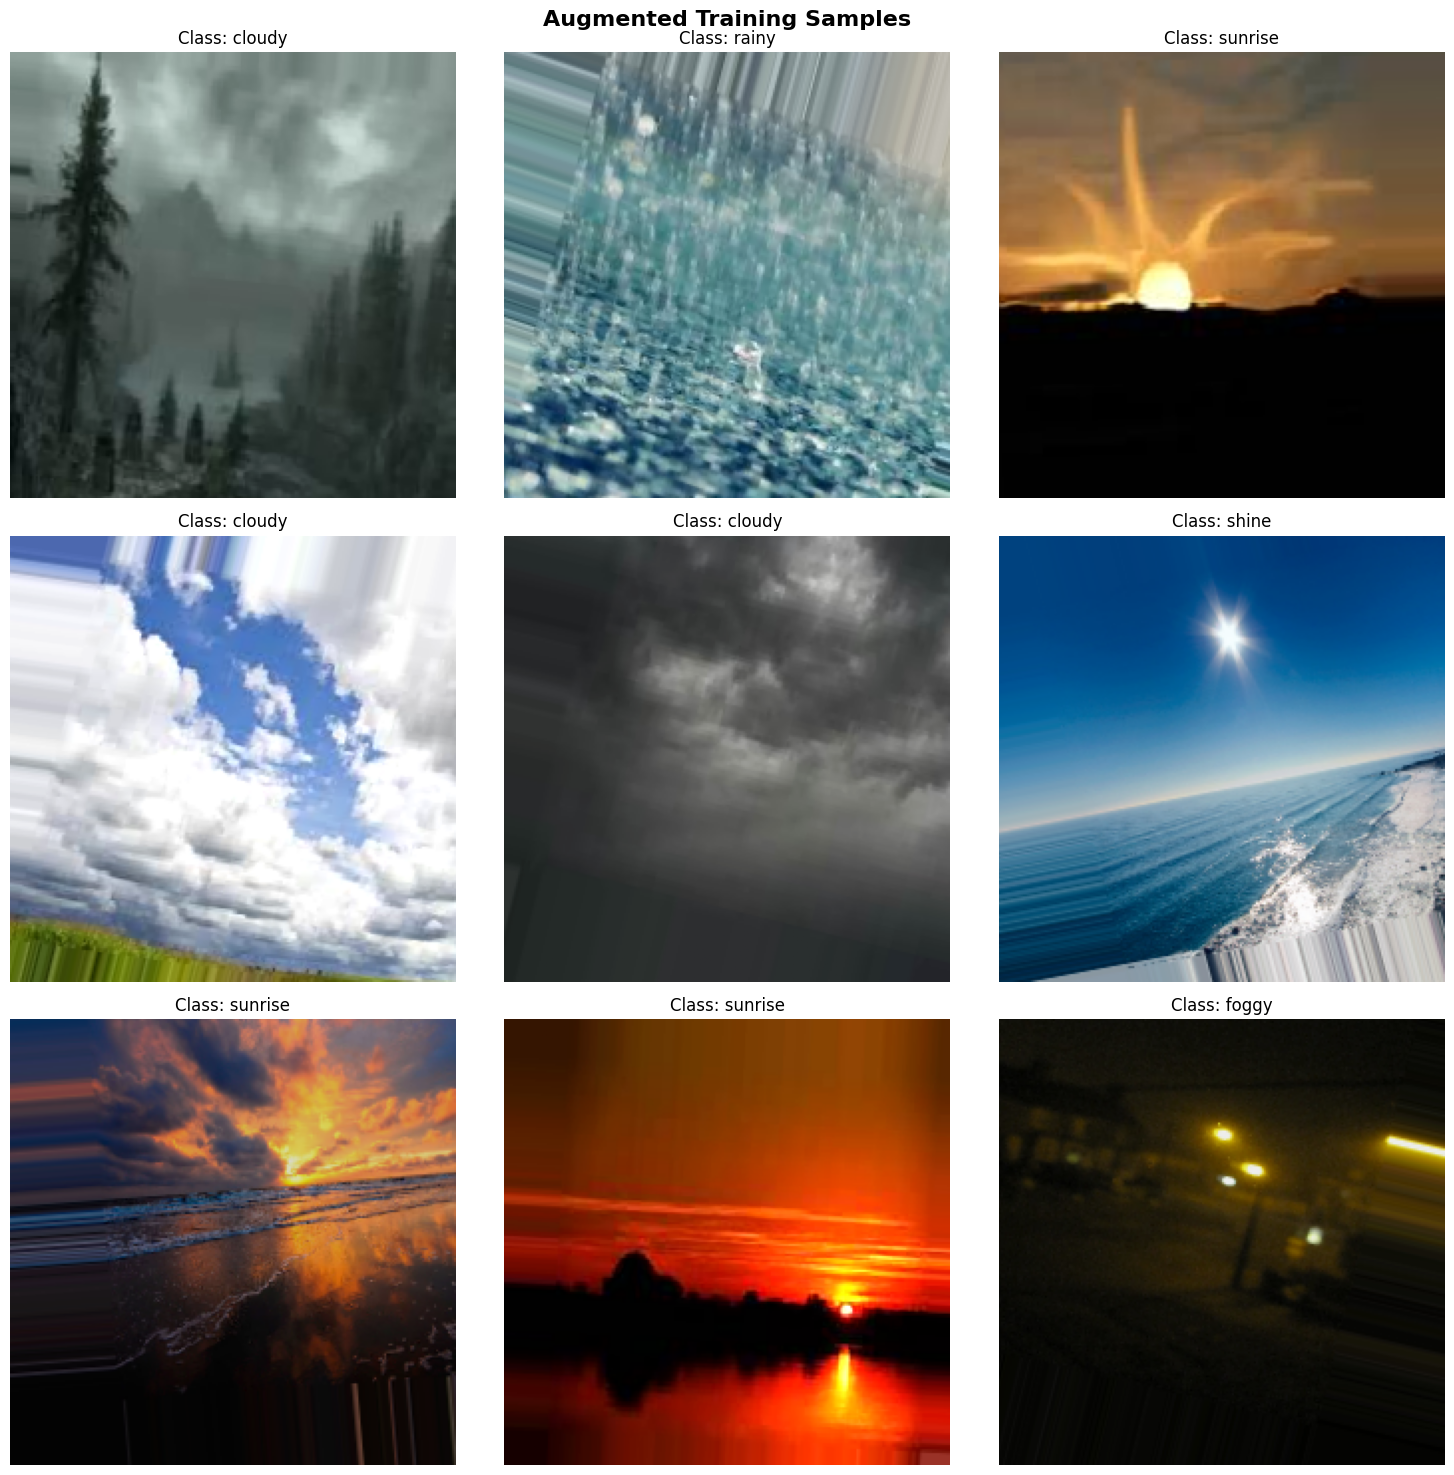

In [ ]:
def visualize_augmentation(generator, num_samples=9):
    """Visualize augmented images"""
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.ravel()

    # Get one batch
    images, labels = next(generator)

    for i in range(min(num_samples, len(images))):
        axes[i].imshow(images[i])
        axes[i].set_title(f'Class: {CLASS_NAMES[int(labels[i])]}', fontsize=12)
        axes[i].axis('off')

    plt.suptitle('Augmented Training Samples', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\nVisualizing augmented training samples...")
visualize_augmentation(train_generator)

SAVE PREPROCESSING INFORMATION

In [ ]:
preprocessing_info = {
    'img_size': IMG_SIZE,
    'batch_size': BATCH_SIZE,
    'num_classes': NUM_CLASSES,
    'class_names': CLASS_NAMES,
    'class_weights': class_weight_dict,
    'train_samples': len(X_train),
    'val_samples': len(X_val),
    'test_samples': len(X_test),
    'total_samples': len(all_image_paths)
}

In [ ]:
# Save as numpy file
os.makedirs(OUTPUT_PATH, exist_ok=True)
np.save(os.path.join(OUTPUT_PATH, 'preprocessing_info.npy'), preprocessing_info)

In [ ]:
# Save split indices for reproducibility
np.save(os.path.join(OUTPUT_PATH, 'X_train.npy'), X_train)
np.save(os.path.join(OUTPUT_PATH, 'X_val.npy'), X_val)
np.save(os.path.join(OUTPUT_PATH, 'X_test.npy'), X_test)
np.save(os.path.join(OUTPUT_PATH, 'y_train.npy'), y_train)
np.save(os.path.join(OUTPUT_PATH, 'y_val.npy'), y_val)
np.save(os.path.join(OUTPUT_PATH, 'y_test.npy'), y_test)